In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib widget
log_folder = 'runs'

from matplotlib import rc
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('axes', titlesize=16)
rc('axes', labelsize=16)
rc('axes', axisbelow=False)
rc('lines',linewidth=1.5)
# lines.markersize : 10
rc('xtick', labelsize=16)
rc('xtick.major',size=10) 
rc('xtick.minor',size=5)
rc('xtick',direction='in')
rc('ytick', labelsize=16)
rc('ytick.major',size=10)
rc('ytick.minor',size=5)
rc('ytick',direction='in')
# rc('legend',fontsize='large')


from jax.scipy.ndimage import map_coordinates

import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update("jax_debug_nans", True)
# jax.config.update("jax_disable_jit", True)

import numpy as np
import jax.numpy as jnp

if hasattr(jnp,'trapz'):
  integrate_trapz = jnp.trapz
else:
  integrate_trapz = jax.scipy.integrate.trapezoid

/home/ohahn/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import sys
sys.path.append("..")
from discoeb.background import evolve_background
from discoeb.cosmo import compute_angular_diameter_distance, get_aprimeoa
from discoeb.perturbations import evolve_perturbations, get_xi_from_P, power_Kaiser, get_power

In [3]:
## Cosmological Parameters

## Cosmological Parameters
## Cosmological Parameters
Tcmb    = 2.7255
YHe     = 0.248
Omegam  = 0.32
Omegab  = 0.05
w_DE_0  = -0.9999
w_DE_a  = 0.00
cs2_DE  = 0.9999
num_massive_neutrinos = 1
mnu     = 0.06  #eV
Tnu     = (4/11)**(1/3) #0.71611 # Tncdm of CLASS
Neff    = 3.046 # -1 if massive neutrino present
N_nu_mass = 1
N_nu_rel = Neff - N_nu_mass * (Tnu/((4/11)**(1/3)))**4
standard_neutrino_neff=Neff+num_massive_neutrinos
h      = 0.67
A_s     = 2.1064e-09
n_s     = 0.96
sigmaz0 = 0.01  # redshift error
sigma8  = 0.816
bias    = 2.0   # bias

# list of parameters with respect to which we take derivatives
fieldnames = ['H_0', '\\Omega_m', '\\Omega_b', 'N_{eff}', 'm_{\\nu}', 'T_{CMB}', 'Y_{He}', '\\sigma_8', 'n_s', 'w_0', '(1+w_a)', 'b_1',  '\\sigma_{z,0}',  'c_a^2']
fiducial_cosmo_param = jnp.array([100*h, Omegam, Omegab, N_nu_rel, mnu, Tcmb, YHe, sigma8, n_s,  w_DE_0, 1+w_DE_a,  bias, sigmaz0,  cs2_DE])

# modes to sample
nmodes = 512
nmu    = 512
kmin   = 1e-4
kmax   = 1e+1
aexp   = 1.0 # scale factor at which to evaluate, can also be a jax.array



In [4]:
def get_param_from_args( args ):
    param = {}
    param['h']      = args[0]/100
    param['Omegam'] = args[1]
    param['Omegab'] = args[2]
    param['Omegak'] = 0.0
    param['A_s']    = 2.1064e-09
    param['sigma8']    = args[7]
    param['n_s']    = args[8]
    param['H0']     = args[0]
    param['Tcmb']   = args[5]
    param['YHe']    = args[6]
    param['Neff']   = args[3] 
    param['Nmnu']   = num_massive_neutrinos
    param['mnu']    = args[4]
    param['w_DE_0'] = args[9]
    param['w_DE_a'] = args[10]-1
    param['cs2_DE'] = args[13]
    param['b1']     = args[11]
    param['k_p']    = 0.05
    param['sigma_z0'] = args[12]

    ## Compute Background evolution
    param = evolve_background(param=param, thermo_module='RECFAST')

    return param


def get_normalisation_factor( *, kmodes, y, param, ind=-1 ):
    h = param['h']
    Pm0 = get_power( k=kmodes, y=y[:,ind,:], param=param, idx=4 )
    Wth = lambda kR : 3*(jnp.sin(kR)-kR*jnp.cos(kR))/(kR)**3
    dsigma = Wth(kmodes/h*8.0)**2 * Pm0 * kmodes**3
    sigma8_2_measured = integrate_trapz( y=(dsigma), x=jnp.log(kmodes) ) / (2*jnp.pi**2)
    return param['sigma8']**2 / sigma8_2_measured

In [5]:
# Compute the observed power spectrum including Alcock-Paczynski 
def Pkmu_of_cosmo( args, *, aexp, args_fiducial ):
    """ Compute the matter power spectrum for a given set of cosmological parameters"""
    
    param = get_param_from_args(args)
    h = param['h']

    param_fiducial = get_param_from_args(args_fiducial)
    h_fiducial = param_fiducial['h']
    
    #..................................................................................................
    #... evolve modes to aexp and a=1.0
    aexp_out = jnp.array([aexp, 1.0])
    y, kmodes = evolve_perturbations( param=param, kmin=kmin*h, kmax=kmax*h, num_k=nmodes, aexp_out=aexp_out, rtol=1e-4, atol=1e-4 )
    # this is redundant as fiducial cosmology does not change, compute outside function...
    y_fiducial, kmodes_fiducial = evolve_perturbations( param=param_fiducial, kmin=kmin*h_fiducial, kmax=kmax*h_fiducial, 
                                                num_k=nmodes, aexp_out=aexp_out, rtol=1e-4, atol=1e-4 )

    #..................................................................................................
    #... compute sigma8 normalisation 
    norm_fac = get_normalisation_factor( kmodes=kmodes, y=y, param=param)
    
    #..................................................................................................
    #... compute redshift-space spectrum using Kaiser formula
    #... add nuisance correction to bias, scale with sigma_8(z)
    bias_euclid = param['b1']
    Pkmu, mu = power_Kaiser( y=y[:,0,:], kmodes=kmodes, bias=bias_euclid, aexp=aexp, nmu=nmu, param=param, mu_sampling=False )
    # normalise to correct sigma_8
    Pkmu *= norm_fac
     # change units of power spectrum to (Mpc/h)**3, where h is not the reference value
    Pkmu *= h**3 

    #... compute Finger-of-God effect, Percival+2004 (should be evaluated on fiducial cosmology)
    norm_fac_fiducial = get_normalisation_factor( kmodes=kmodes_fiducial, y=y_fiducial, param=param_fiducial)
    dPtt = get_power( k=kmodes_fiducial, y=y_fiducial[:,0,:], param=param_fiducial, idx=5 ) * kmodes_fiducial * norm_fac_fiducial 
    sigma_p_2 = integrate_trapz( y=(dPtt), x=jnp.log(kmodes_fiducial) ) / (6*jnp.pi**2) #* (h/h_fiducial)
    # F_FoG = 1. / (1. + (kmodes[:,None]/h)**2 * mu[None,:]**2 * sigma_p_2)
    F_FoG = 1. / (1. + (kmodes[:,None])**2 * mu[None,:]**2 * sigma_p_2)
    Pkmu *= F_FoG
    
    #..................................................................................................
    #... compute Alcock-Paczynski 
    Da = compute_angular_diameter_distance( aexp=aexp, param=param )
    Da_fiducial = compute_angular_diameter_distance( aexp=aexp, param=param_fiducial )
    Ha = get_aprimeoa( param=param, aexp=aexp)
    Ha_fiducial = get_aprimeoa( param=param_fiducial, aexp=aexp)

    print(Da,Da_fiducial, Ha, Ha_fiducial)

    qperp = Da/Da_fiducial
    qpara = Ha_fiducial/Ha

    # evaluate at observed k,µ
    logkmodes = jnp.log(kmodes)
    kobs   = kmodes[:,None] / qperp * jnp.sqrt(1 + mu[None,:]**2 * (qperp**2/qpara**2-1))
    muobs  = mu[None,:] * qperp/qpara / jnp.sqrt(1 + mu[None,:]**2 * (qperp**2/qpara**2-1)) * jnp.ones((nmodes,nmu))
    ikobs  = (jnp.log(kobs) - jnp.min(logkmodes))/(jnp.max(logkmodes)-jnp.min(logkmodes)) * nmodes
    imuobs = (muobs - jnp.min(mu))/(jnp.max(mu)-jnp.min(mu)) * nmu
    Pkmu   = map_coordinates( Pkmu, (ikobs.flatten(),imuobs.flatten()), mode='mirror', order=1 ).reshape((nmodes,nmu))

    # Pkmu = Pkmu.at[ (kmodes > kmax_cut * h_fiducial) | (kmodes < kmin_cut * h_fiducial) ].set(0.0)

    # apply Alcock-Pacinski Jacobian
    Pkmu *= 1. / (qperp**2 * qpara)

    #..................................................................................................
    #... photo/spectro-z error, cut-off position does not depend on expansion history
    # consider this remark from arXiv:1910.09273
    #  "We note that the damping due to redshift errors does not vary with changes in the 
    #   expansion history, since k_\parallel \propto H(z) and \sigma_r \propto 1/H(z)"
    # so H=aprimeoa is the fiducial one, but kmodes also needs to be rescaled by k/h*h_fiducial
    # Fkmu = jnp.exp( -(kmodes[:,None] / qpara / Ha )**2 * mu[None,:]**2 * param['sigma_z0']**2 )
    # Pkmu *= Fkmu

    return Pkmu, mu, jnp.arccos(mu), kmodes/h
    

In [6]:
def Pk_of_cosmo( args ):
    """ Compute the matter (b+c) power spectrum for a given set of cosmological parameters"""
    param = get_param_from_args(args)
    h = param['h']

    ## Compute Background evolution
    param = evolve_background(param=param, thermo_module='RECFAST')

    # Compute Perturbations
    # lmaxg  = 12
    # lmaxgp = 12
    # lmaxr  = 17
    # lmaxnu = 17
    # nqmax  = 15

    rtol   = 1e-4
    atol   = 1e-4

    aexp_out = jnp.atleast_1d(aexp)
    kmodes   = jnp.geomspace(kmin, kmax, nmodes)

    y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out,
                                    #   lmaxg=lmaxg, lmaxgp=lmaxgp, lmaxr=lmaxr, lmaxnu=lmaxnu, nqmax=nqmax,
                                       rtol=rtol, atol=atol )

    # Pkmu, mu, theta = power_Kaiser( y=y[:,-1,:], kmodes=kmodes, b=b, aexp=aexp_out[-1], sigma_z = sigmaz, nmu=nmu, param=param )


    return y, kmodes/h


In [7]:
# compute the fiducial power spectrum
Pkmu, mu, theta, kmodes = Pkmu_of_cosmo( fiducial_cosmo_param, aexp=0.3, args_fiducial = fiducial_cosmo_param )
mu = jnp.append( mu, mu[1:-1][::-1])
theta = jnp.append( theta, 2*jnp.pi-theta[1:-1][::-1] )
kmodes = kmodes
Pkmu = jnp.hstack( (Pkmu, Pkmu[:,1:-1][:,::-1]) )

1730.1971673241296 1730.1971673241296 0.0002379269529033115 0.0002379269529033115


In [8]:
# compute the derivative of the power spectrum with respect to the cosmological parameters, this takes some time... (ca. 2min, incl. compilation on RTX3090)
dPkmu_dcosmo = jax.jacfwd( Pkmu_of_cosmo )
dPkmu,_,_,_ = dPkmu_dcosmo( fiducial_cosmo_param, aexp=0.3, args_fiducial = fiducial_cosmo_param )
dPkmu = jnp.hstack( (dPkmu, dPkmu[:,1:-1][:,::-1]) )

Traced<ConcreteArray(1730.1971673241296, dtype=float64)>with<JVPTrace(level=2/0)> with
  primal = Array(1730.19716732, dtype=float64)
  tangent = Traced<ShapedArray(float64[])>with<BatchTrace(level=1/0)> with
    val = Array([-2.57520351e+01, -1.49223100e+03,  0.00000000e+00, -4.41013972e-02,
       -3.53294330e+01, -2.75247351e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -3.01380221e+02, -7.17638597e+01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00], dtype=float64)
    batch_dim = 0 1730.1971673241296 Traced<ConcreteArray(0.0002379269529033115, dtype=float64)>with<JVPTrace(level=2/0)> with
  primal = Array(0.00023793, dtype=float64)
  tangent = Traced<ShapedArray(float64[])>with<BatchTrace(level=1/0)> with
    val = Array([3.53391443e-06, 3.40425272e-04, 0.00000000e+00, 1.44730468e-08,
       8.05746177e-06, 6.69941186e-07, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.31590440e-05, 9.69417939e-06, 0.00000000e+00,
       0.00000000e+00, 0.00000

In [9]:
dPkmu.shape

(512, 1022, 14)

In [10]:
Pkmu.shape

(512, 1022)

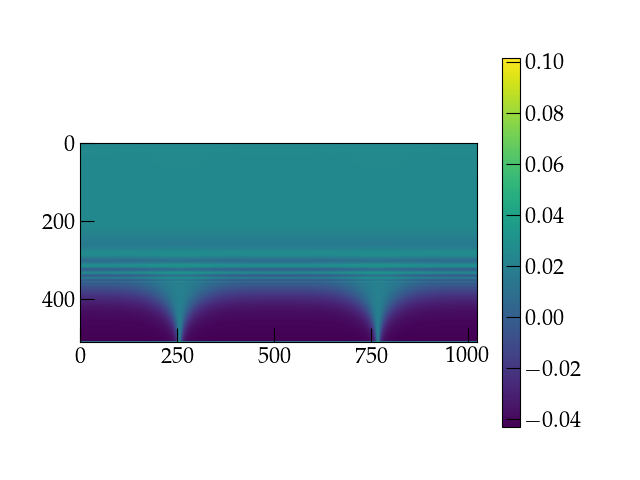

In [11]:
fig,ax = plt.subplots()
# ax.imshow(dPkmu[...,1])
ii = Pkmu < 1e-10
myim = dPkmu[...,0] / Pkmu
# myim = Pkmu
myim = myim.at[ ii].set( 0.0 )
im=ax.imshow(myim)#,vmin=-0.01,vmax=0.01)
plt.colorbar(im)


Text(0, 0.5, '$\\log_{10} k$')

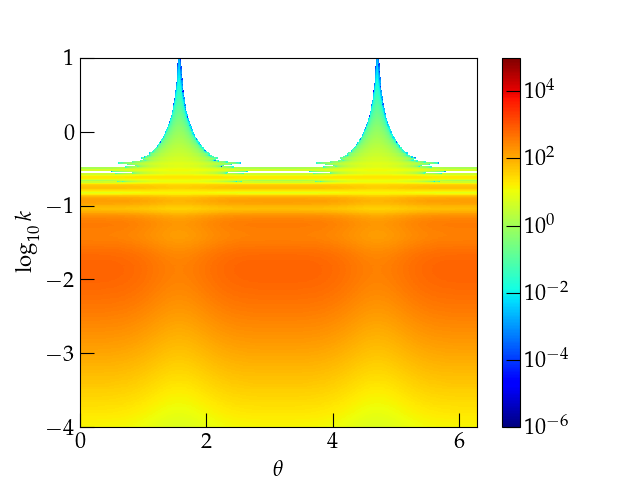

In [12]:

# create a map of the powerspectrum
fig, ax = plt.subplots()

im = ax.pcolor( theta, jnp.log10(kmodes), dPkmu[...,0], cmap='jet', shading='auto', norm=colors.LogNorm(vmin=1e-6, vmax=1e+5) )
plt.colorbar(im, ax=ax)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\log_{10} k$')

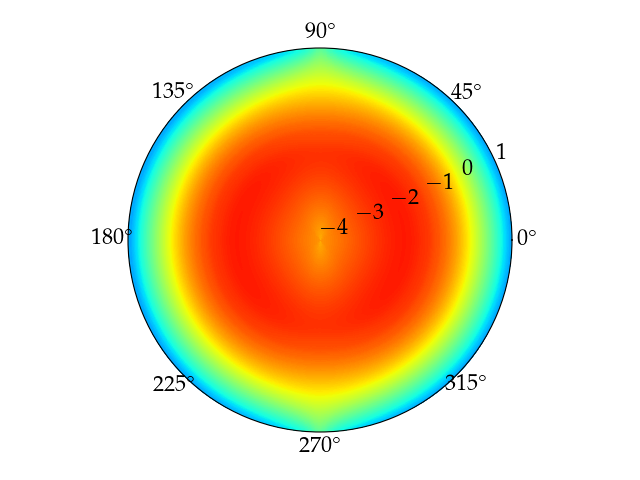

In [13]:
# create a polar map
fig, ax = plt.subplots()
ax.set_axis_off()
ax = fig.add_axes([0.1,0.1,0.8,0.8],polar=True)
ax.grid(False)
ax.pcolormesh( theta, jnp.log10(kmodes), Pkmu,edgecolors='face', norm=colors.LogNorm(vmin=1e-7, vmax=1e6),
                   cmap='jet', shading='auto')


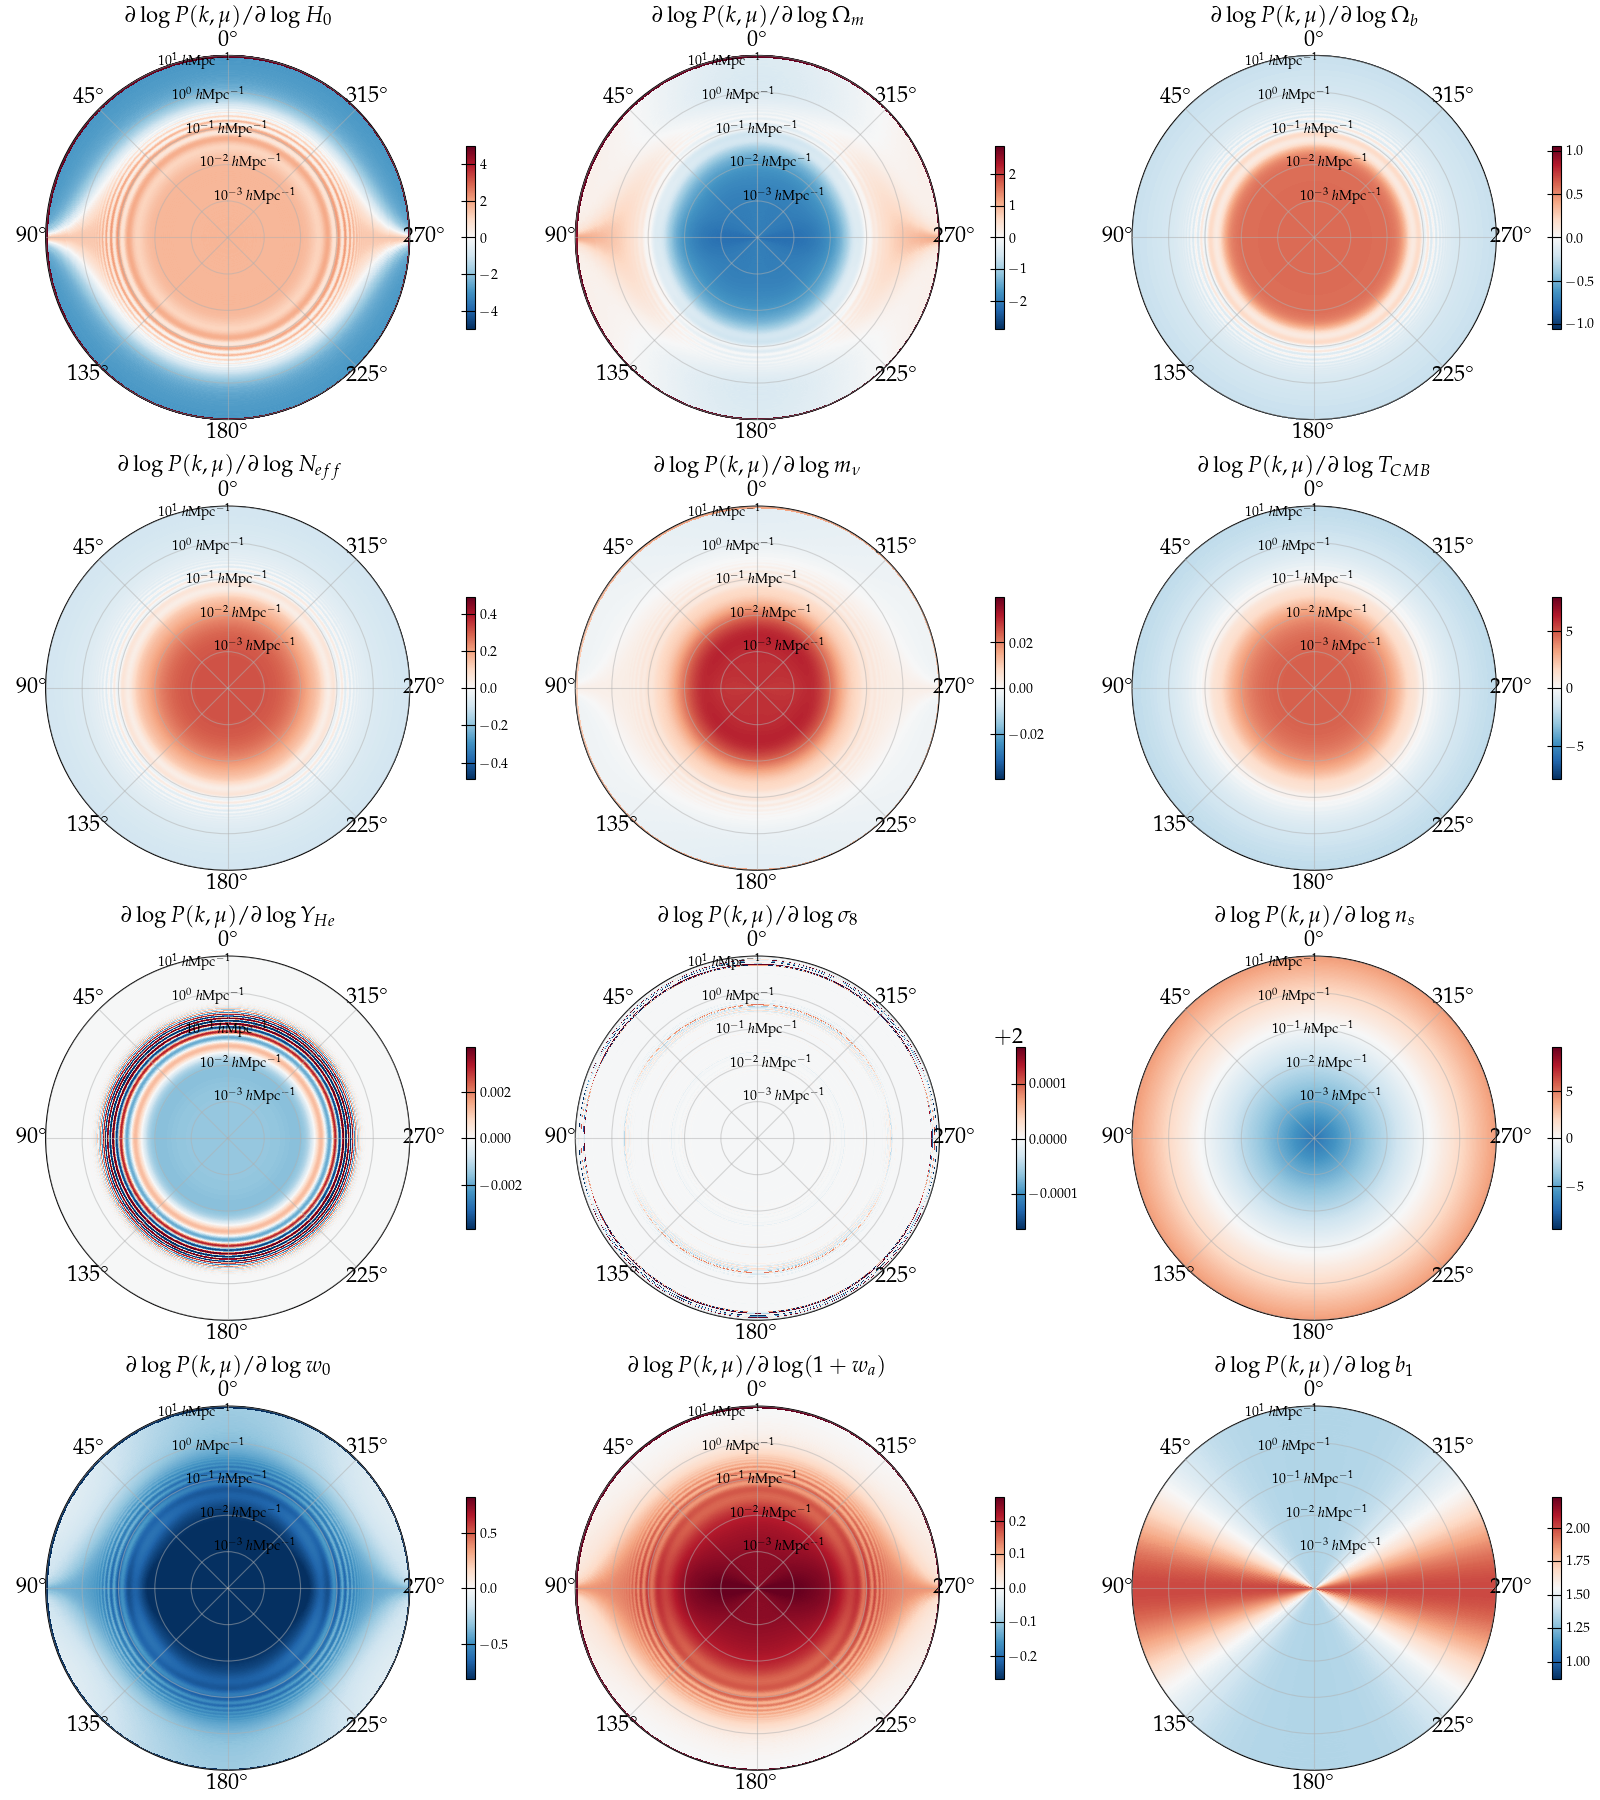

In [17]:

# create a polar map of the derivative of the power spectrum with respect to the cosmological parameters
# fig, ax = plt.subplots(layout='constrained')
fig,axs = plt.subplots(4,3,sharex=True,figsize=(16,18),layout='constrained',subplot_kw={'projection': 'polar'})

for i,ff in enumerate(fieldnames[:12]):
    iy = i%3
    ix = i//3
    dlogPkmu = dPkmu[...,i]/Pkmu

    ax = axs[ix,iy]
    ax.grid(False)
    ax.pcolormesh( theta, jnp.log10(kmodes), dPkmu[...,i]/Pkmu, edgecolors='face',
                      cmap='RdBu_r', shading='auto', rasterized=True)
    
    dlogPkmu = fiducial_cosmo_param[i] * dPkmu[...,i]/Pkmu
    # cc =3*np.std(np.abs(dlogPkmu)[~np.isnan(np.abs(dlogPkmu))])
    cc =3*np.std(dlogPkmu[~np.isnan(np.abs(dlogPkmu))])
    m=0.0
    if ff in ['b_1']:
        m=np.mean(dlogPkmu[~np.isnan(np.abs(dlogPkmu))])

    im = ax.pcolormesh( theta, jnp.log10(kmodes), dlogPkmu, edgecolors='face',
                    cmap='RdBu_r', shading='auto', rasterized=True, vmin=-cc+m,vmax=cc+m)

    cbar = plt.colorbar(im, ax=ax, shrink=0.5)
    cbar.ax.tick_params(labelsize=10)


    ax.set_theta_zero_location('N')
    ax.grid(True,alpha=0.5)
    ax.set_rticks([-3,-2,-1,0,1])
    ax.set_yticklabels(['$10^{-3}\\;h{\\rm Mpc}^{-1}$','$10^{-2}\\;h{\\rm Mpc}^{-1}$','$10^{-1}\\;h{\\rm Mpc}^{-1}$','$10^{0}\\;h{\\rm Mpc}^{-1}$','$10^{1}\\;h{\\rm Mpc}^{-1}$'],size=10)
    ax.set_title(f'$\partial \log P(k,\mu)/\partial \log {fieldnames[i]}$')

plt.savefig('dlogPkmu_dcosmo.pdf',bbox_inches='tight', dpi=300)
# plt.savefig('dlogPkmu_dcosmo_dpi300.png',bbox_inches='tight', dpi=300)


Text(0.5, 1.0, '$\\partial \\log P(k,\\mu)/\\partial c_a^2$')

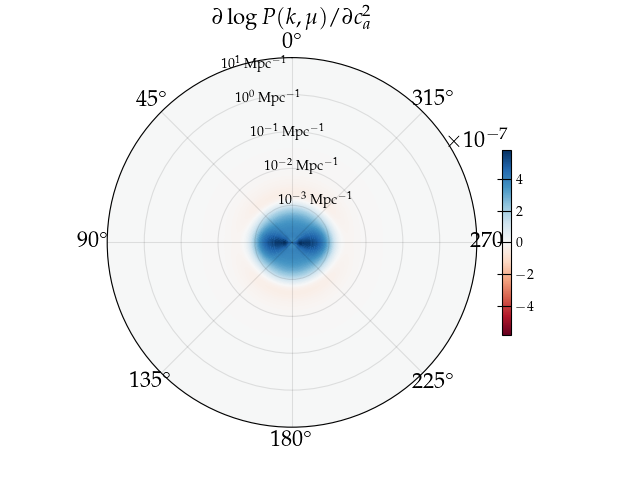

In [15]:
# create a polar map of the derivative of the power spectrum with respect to the cosmological parameters
# fig, ax = plt.subplots(layout='constrained')

# 0 : 1e-4 , 1e4, negative
# 1 : -3, 3
# 2 : -1, 1 
# 3 : -1/2, 1/2

fig,ax = plt.subplots(subplot_kw={'projection': 'polar'})
ivar = 13


ax.grid(False)
dlogPkmu = fiducial_cosmo_param[ivar] * dPkmu[...,ivar]/Pkmu
cc = np.max(np.abs(dlogPkmu)[~np.isnan(np.abs(dlogPkmu))])
im = ax.pcolormesh( theta, jnp.log10(kmodes), dlogPkmu, edgecolors='face',
                  cmap='RdBu', shading='auto', rasterized=True, vmin=-cc,vmax=cc)#, vmin=-1, vmax=1 )#, vmin=-20000, vmax=+20000)#, norm=colors.LogNorm(vmin=1e-4, vmax=1e+4) )#vmin=-100000, vmax=0)

cbar = plt.colorbar(im, ax=ax, shrink=0.5)
cbar.ax.tick_params(labelsize=10)

ax.set_theta_zero_location('N')
ax.grid(True,alpha=0.1,c='k')
ax.set_rticks([-3,-2,-1,0,1])
ax.set_yticklabels(['$10^{-3}\\;{\\rm Mpc}^{-1}$','$10^{-2}\\;{\\rm Mpc}^{-1}$','$10^{-1}\\;{\\rm Mpc}^{-1}$','$10^{0}\\;{\\rm Mpc}^{-1}$','$10^{1}\\;{\\rm Mpc}^{-1}$'],size=10)
ax.set_title(f'$\partial \log P(k,\mu)/\partial {fieldnames[ivar]}$')